# Import

In [1]:

import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
import scipy.io as sio

sys.path.append(os.path.abspath("../src"))

from utils.mpiifacegaze_dataset import *
import torch
from torch.utils.data import DataLoader
from tracker import GazeModel
from utils.mpiifacegaze_dataset import *

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-07-08 02:33:09.380678: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 02:33:09.388026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751934789.396500  214746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751934789.399052  214746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751934789.405656  214746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print(f"{torch.cuda.get_device_name(torch.cuda.current_device())}")

NVIDIA GeForce RTX 4090


# Preprocessing - Stats

In [3]:
dataset = MPIIFaceGazeDataset(root_dir='../dataset/MPIIFaceGaze/')
df = dataset.to_dataframe(normalize=False)

In [4]:
print(df.head())

  subject                                    img_path  gaze_x  gaze_y
0     p00  ../dataset/MPIIFaceGaze/p00/day01/0005.jpg   476.0   758.0
1     p00  ../dataset/MPIIFaceGaze/p00/day01/0030.jpg  1078.0   693.0
2     p00  ../dataset/MPIIFaceGaze/p00/day01/0031.jpg   126.0   598.0
3     p00  ../dataset/MPIIFaceGaze/p00/day01/0038.jpg   211.0    69.0
4     p00  ../dataset/MPIIFaceGaze/p00/day01/0063.jpg   878.0   752.0


In [5]:
len(dataset)

37667

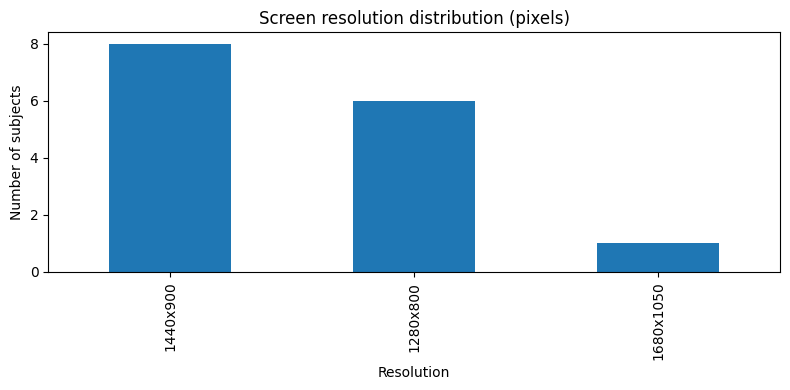

In [6]:
dataset.plot_screen_size_histogram()

In [7]:
df = dataset.to_dataframe(normalize=True)

In [8]:
df

,subject,img_path,gaze_x,gaze_y
0,p00,../dataset/MPIIFaceGaze/p00/day01/0005.jpg,0.371875,0.947500
1,p00,../dataset/MPIIFaceGaze/p00/day01/0030.jpg,0.842187,0.866250
2,p00,../dataset/MPIIFaceGaze/p00/day01/0031.jpg,0.098437,0.747500
3,p00,../dataset/MPIIFaceGaze/p00/day01/0038.jpg,0.164844,0.086250
4,p00,../dataset/MPIIFaceGaze/p00/day01/0063.jpg,0.685937,0.940000
...,...,...,...,...
37662,p14,../dataset/MPIIFaceGaze/p14/day07/0196.jpg,0.506944,0.153333
37663,p14,../dataset/MPIIFaceGaze/p14/day07/0197.jpg,0.668750,0.892222
37664,p14,../dataset/MPIIFaceGaze/p14/day07/0198.jpg,0.929861,0.890000
37665,p14,../dataset/MPIIFaceGaze/p14/day07/0199.jpg,0.945833,0.102222


In [9]:
generate_means(df)

libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1751934795.413326  214746 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751934795.423730  214922 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4090)
Computing mean tensors:   0%|          | 0/1178 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751934795.435683  214881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751934795.443982  214907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751934795.445702  214901 landmark_proj

Means saved successfully in:
  → ../src/mat/mean_face_224_MPIIFace.mat
  → ../src/mat/mean_left_224_MPIIFace.mat
  → ../src/mat/mean_right_224_MPIIFace.mat


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_dataset = FaceGazeDataset(train_df)
test_dataset = FaceGazeDataset(test_df)


I0000 00:00:1751927613.417735  185041 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751927613.431500  186748 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4090)
W0000 00:00:1751927613.439868  186721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1751927613.440623  185041 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1751927613.449547  186735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1751927613.453064  186782 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4090)


W0000 00:00:1751927613.456255  186754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751927613.466553  186773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
model = GazeModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20